In [2]:
import numpy as np 
from scipy import stats
from scipy.stats import pearsonr,spearmanr
from numpy.linalg import norm,eig
from astropy.io import ascii
import matplotlib.pyplot as plt
import random
from sub_dist_functions import get_eigs, get_radii, random_rotation,rotate,transform

In [3]:
def bs_mass_frac_err(mass_frac_arr,n_boot,n_samp,p1=15.9,p2=84.1):
    n_rad, n_halos = np.shape(mass_frac_arr.T)
    boot_vals = np.zeros((n_boot,n_samp,n_rad))
    for i in range(n_boot):
        for j in range(n_samp):
            indx = random.randint(0, n_halos-1)
            boot_vals[i][j]+=mass_frac_arr[indx]
    meds = np.median(boot_vals,axis=1)
    percentiles = np.percentile(meds,[p1,p2],axis=0)
    
    return percentiles

In [4]:
def random_rotation(I,pos):
    ## I is eigenvector array calculated from moment of inertia
    np.random.seed()
    tx=np.random.random()*90.0
    ty=np.random.random()*90.0
    tz=np.random.random()*90.0

    new_I = rotate(I,tx,ty,tz)
    new_pos = transform(pos,new_I).T

    para = np.zeros(np.shape(new_pos))
    perp = np.zeros(np.shape(new_pos))
    p = np.zeros(len(new_pos))
    t = np.zeros(len(new_pos))
    hA = new_I[0]
    hB = new_I[1]
    
    for i in range(len(new_pos)):
        para[i]+=np.dot(new_pos[i],hA/norm(hA))*(hA/norm(hA))
        perp[i]+=new_pos[i]-para[i]
        t[i]+=np.arccos(np.dot(new_pos[i],hA)/(norm(new_pos[i])*norm(hA)))
        p[i]+=np.arccos(np.dot(perp[i],hB)/(norm(hB)*norm(perp[i])))
    r = np.sqrt(np.sum(perp**2,axis=1))

    return r

In [5]:
names =['scale','ID','desc_scale','desc_id','num_prog','pid','upid','desc_pid',
    'phantom','sam_mvir','Mvir','Rvir','Rs', 'vrms', 'mmp', 'scale_of_last_MM',
    'Vmax', 'X','Y','Z','VX','VY','VZ','JX','JY','JZ','Spin','Breadth_first_ID',
    'Depth_first_ID','Tree_root_ID','Orig_halo_ID','Snap_num',
    'Next_coprogenitor_depthfirst_ID','Last_progenitor_depthfirst_ID',
    'Rs_Klypin','Mvir_all','M200b','M200c','M500c','M2500c','Xoff','Voff',
    'spin_bullock','b_to_a','c_to_a','A[x]','A[y]','A[z]','b_to_a(500c)',
    'c_to_a(500c)','A[x](500c)','A[y](500c)','A[z](500c)','T/|U|','Macc',
    'Mpeak','Vacc','Vpeak','Halfmass_Scale','Acc_Rate_Inst','Acc_Rate_100Myr',
    'Acc_Rate_Tdyn']

In [5]:
def eq_vol(rvir,num_bins,num_rad):
    radii = np.zeros(num_rad+1)
    tot_vol = (4/3)*np.pi*rvir**3
    bin_vol = (tot_vol/num_bins)*(3/4)/np.pi

    radii[0]+=0.
    j = 1

    for i in range(num_rad):
        r = (bin_vol+radii[j-1]**3)**(1/3)
        radii[j]+=r

        j+=1

    return radii
    
    

In [6]:
host_vals = ascii.read('host_og_vals.table', format = 'commented_header') 

rvirs = host_vals['rvir']
mvirs = host_vals['mvir']
hostx = host_vals['hostx']
hosty = host_vals['hosty']
hostz = host_vals['hostz']
hostvx = host_vals['hostvx']
hostvy =host_vals['hostvy']
hostvz = host_vals['hostvz']
host_shapes = host_vals['host_shapes']
host_spins = host_vals['host_spins']
host_cs = host_vals['host_cs']
hostJx = host_vals['hostJx']
hostJy = host_vals['hostJy']
hostJz = host_vals['hostJz']

halo_names = []
host_ids = []

with open('hlist_halo_ids.txt') as f:
    for l in f:
        j = 0
        this_halo, host_id = l.split()#, block, _ = l.split()
        halo_names.append(this_halo)
        host_ids.append(host_id)
        j+=1

host_I = np.load('mwm_host_inertia_tensor_no_norm.npy')



In [10]:
mass_frac_A = np.zeros((int(len(halo_names)),28))
mass_frac_random = np.zeros((int(len(halo_names)*5),28))
i = 0
n = 0
for halo in halo_names:
    hostvalues = ascii.read('/Users/lmezini/proj_2/rs_files/Halo{}/hlist.list'.format(halo),names=names)
    loc = int(np.where(hostvalues['ID']==int(host_ids[i]))[0][0])
    if type(loc)==int:
        halo_rvir = hostvalues['Rvir'][loc]
        halo_mvir = hostvalues['Mvir'][loc]
        host_x = hostvalues['X'][loc]
        host_y = hostvalues['Y'][loc]
        host_z = hostvalues['Z'][loc]

        mvirs[i] = halo_mvir
        rvirs[i] = halo_rvir

        hostvalues.remove_row(loc)

        rad_cuts = eq_vol(halo_rvir,1000,27)
        whlimit = np.where(hostvalues['upid']==int(host_ids[i]))
        subs = hostvalues[whlimit]
        whlimit = np.where(subs['Vmax']>10.)
        subs = subs[whlimit]

        dist = np.sqrt((subs['X']-host_x)**2+(subs['Y']-host_y)**2+(subs['Z']-host_z)**2)
        whlimit = np.where(dist<halo_rvir*0.001)
    
        subs = subs[whlimit]
        del dist
        pos = np.array(((subs['X']-host_x),(subs['Y']-host_y),(subs['Z']-host_z)))
        hw, hv = get_eigs(host_I[i],rvirs[i])
        rs = get_radii(pos.T,hv)
        m = subs['Mvir']
        j = 1
        for f in range(len(rad_cuts)-1):
            mass_frac_A[i][j] += (np.sum(m[rs<(0.001*rad_cuts[j])])-np.sum(m[rs<(0.001*rad_cuts[j-1])]))/halo_mvir
            j+=1
        for k in range(5):
            rand_r = random_rotation(hv,pos.T)
            print(rand_r)
            j = 1
            for f in range(len(rad_cuts)-1):
                mass_frac_random[n][j] += (np.sum(m[rand_r<(0.001*rad_cuts[j])])-np.sum(m[rand_r<(0.001*rad_cuts[j-1])]))/halo_mvir
                j+=1
            n+=1
        #np.save('shot_noise_mass_frac_A_x{}.npy'.format(n),mass_frac_A)
    i+=1


[0.10461033 0.05492361 0.10487187 0.07286285 0.11479683 0.13557645
 0.05035816 0.1282854  0.08870933 0.09396527 0.06574935 0.03198817
 0.10296481 0.0734546  0.06419522 0.00741206 0.15178455 0.1445747
 0.14663449 0.09849488 0.13636606 0.16439446 0.18959169 0.17047733
 0.13248428 0.09763354 0.09333679 0.0750255  0.03587446 0.15631566
 0.03715296 0.03865272 0.02592306 0.10259462 0.14828273 0.14585288
 0.14397674 0.18344746 0.18871936 0.16168151 0.11635441 0.04825612
 0.12739534 0.04323441 0.03268663 0.15907073 0.15153051 0.10303606
 0.0696638  0.12715634 0.15938888 0.19060683 0.05709236 0.1219877
 0.06366697 0.08291628 0.09890766 0.10528189 0.07902582 0.16954199
 0.10310237 0.14588231 0.14392664 0.05029672 0.03671935 0.11298159
 0.07344468 0.04183953 0.15230042 0.07470938 0.06436669 0.1137721
 0.08769196 0.17150534 0.04953792 0.12445246 0.16251406 0.02980125
 0.12320858 0.13143643 0.16183609 0.08349282 0.12314623 0.07328009
 0.03808364 0.1324788  0.05545335 0.05858024 0.07548842 0.1610505

KeyboardInterrupt: 

In [391]:
#np.save('mwm_mass_frac_A_eq_vol.npy',mass_frac_A)
#np.save('mwm_mass_frac_rand_eq_vol.npy',mass_frac_random)

In [409]:
err = bs_mass_frac_err(mass_frac_A,1000,45,p1=15.9,p2=84.1)

In [394]:
A = np.median(mass_frac_A,axis=0)
R = np.median(mass_frac_random,axis=0)

/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_14743/2727778110.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(rad_fracs,np.log10(A)-np.log10(R))
/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_14743/2727778110.py:1: RuntimeWarning: invalid value encountered in subtract
  plt.plot(rad_fracs,np.log10(A)-np.log10(R))
/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_14743/2727778110.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(rad_fracs,np.log10(err[0])-np.log10(R),np.log10(err[1])-np.log10(R),alpha=0.3)
/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_14743/2727778110.py:2: RuntimeWarning: invalid value encountered in subtract
  plt.fill_between(rad_fracs,np.log10(err[0])-np.log10(R),np.log10(err[1])-np.log10(R),alpha=0.3)


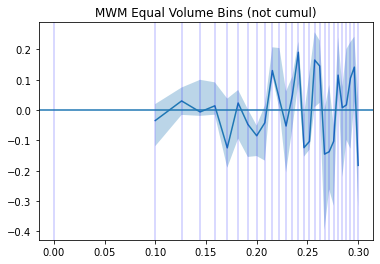

In [411]:
plt.plot(rad_fracs,np.log10(A)-np.log10(R))
plt.fill_between(rad_fracs,np.log10(err[0])-np.log10(R),np.log10(err[1])-np.log10(R),alpha=0.3)
for r in rad_fracs:
    plt.axvline(r,c='b',alpha=0.2)
plt.axhline(0)
plt.title('MWM Equal Volume Bins (not cumul)')
plt.show()

In [1]:
mass_frac_A = np.zeros((int(len(halo_names)),7))
mass_frac_random = np.zeros((int(len(halo_names)*5),7))


rad_cuts = [0.5,0.1,0.15,0.2,0.3,0.4,0.5]

i = 0
n = 0
for halo in halo_names:
    hostvalues = ascii.read('/Users/lmezini/proj_2/rs_files/Halo{}/hlist.list'.format(halo),names=names)
    loc = int(np.where(hostvalues['ID']==int(host_ids[i]))[0][0])
    if type(loc)==int:
        halo_rvir = hostvalues['Rvir'][loc]
        halo_mvir = hostvalues['Mvir'][loc]
        host_x = hostvalues['X'][loc]
        host_y = hostvalues['Y'][loc]
        host_z = hostvalues['Z'][loc]

        mvirs[i] = halo_mvir
        rvirs[i] = halo_rvir

        hostvalues.remove_row(loc)

        whlimit = np.where(hostvalues['upid']==int(host_ids[i]))
        subs = hostvalues[whlimit]
        whlimit = np.where(subs['Vmax']>10.)
        subs = subs[whlimit]

        dist = np.sqrt((subs['X']-host_x)**2+(subs['Y']-host_y)**2+(subs['Z']-host_z)**2)
        whlimit = np.where(dist<halo_rvir*0.001)
    
        subs = subs[whlimit]
        del dist

        pos = np.array(((subs['X']-host_x),(subs['Y']-host_y),(subs['Z']-host_z)))
        hw, hv = get_eigs(host_I[i],halo_rvir)
        rs = get_radii(pos.T,hv)
        m = subs['Mvir']

        j = 0
        for f in range(len(rad_cuts)):
            mass_frac_A[i][j] += (np.sum(m[rs<(0.001*halo_rvir*rad_cuts[j])]))/halo_mvir
            j+=1
        for k in range(5):
            rand_r = random_rotation(hv,pos.T)
            j = 0
            for f in range(len(rad_cuts)):
                mass_frac_random[n][j] += (np.sum(m[rand_r<(0.001*halo_rvir*rad_cuts[j])]))/halo_mvir
                j+=1
            n+=1
        #np.save('shot_noise_mass_frac_A_x{}.npy'.format(n),mass_frac_A)
    i+=1


NameError: name 'np' is not defined

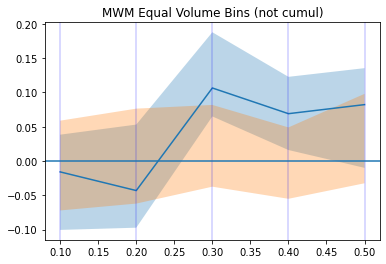

In [15]:
err = bs_mass_frac_err(mass_frac_A,1000,45,p1=15.9,p2=84.1)
err2 = bs_mass_frac_err(mass_frac_random,1000,45,p1=15.9,p2=84.1)

A = np.median(mass_frac_A,axis=0)
R = np.median(mass_frac_random,axis=0)

plt.plot(rad_cuts,np.log10(A)-np.log10(R))
plt.fill_between(rad_cuts,np.log10(err[0])-np.log10(R),np.log10(err[1])-np.log10(R),alpha=0.3)
plt.fill_between(rad_cuts,np.log10(err2[0])-np.log10(R),np.log10(err2[1])-np.log10(R),alpha=0.3)

for r in rad_cuts:
    plt.axvline(r,c='b',alpha=0.2)
plt.axhline(0)
plt.title('MWM Equal Volume Bins (not cumul)')
plt.show()